### Tutorial 3: Integrating the fragility curve with the probability density function of the waterlevel, and derive influence coefficients after integration

#### Create base `class DStabilityFragilityCurve` for fragility curve operations

In [1]:
# Loading the necesary packages
import json # for reading fragility curves in D-Stability .json format
import numpy as np # for array calculations
import scipy.stats as st # for statisitcal functions
import pandas as pd # for reading excel files
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d # for linear interpolation and extrapolation outside the range
from statistics import NormalDist
from scipy.stats import norm
from scipy.stats import gumbel_r

In [2]:
# Define some static functions

def densify_extrapolate(x, y, xrange, xdelta):
    xnew = np.arange(xrange[0], xrange[1] + xdelta, xdelta)
    f = interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')
    ynew = f(xnew)
    return xnew, ynew    

# Preprocess the DStabilityFragilityCurve class
class DStabilityFragilityCurve:
    
    def __init__(self, label, filename):
        """ --- documentation generated by AI model
        Initialize a DStabilityFragilityCurve object, and then
        calls `preprocess_rawdata()` to save the raw data in a structured way

        Args:
            label (str): The label for the DStabilityFragilityCurve object.
            filename (str): The name of the JSON file containing the raw data.

        Returns:
            None.

        Raises:
            FileNotFoundError: If the specified file does not exist.

        """     
        self.Label = label
        with open(filename, 'r') as f:
            self.rawdata = json.load(f)
        self.preprocess_rawdata()
        
    def preprocess_rawdata(self):
        """
        Notes
        """ 
        self.FragilityPoints = self.rawdata.get('Calculations')
        self.Stochasts = self.rawdata.get('Stochasts')
        self.Correlations = self.rawdata.get('Correlations')
        
        self.h = [point.get('WaterLevel') for point in self.FragilityPoints]
        self.b = [point.get('Beta') for point in self.FragilityPoints]
        self.bb =[ -1* point.get('Beta') for point in self.FragilityPoints]
        self.p = norm.cdf(self.bb)
        self.stochasts = {}
        for stochast in self.Stochasts:
            if stochast.get('ParameterType') == 'ModelFactor':
                self.stochasts.update({stochast.get('Id'): stochast.get('ParameterType')})
            else:
                self.stochasts.update({stochast.get('Id'): stochast.get('ParameterType')+
                                       '.'+stochast.get('Label')})
    
    def get_scenario_probability(self, file):
        # Import the scenario probabliity (weights) from excel file. 
        # Note the column headers match the labels of the fragility curve
        scenario_probability_data = pd.read_excel(file)
        self.scenario_h = np.array(scenario_probability_data['h'])
        self.scenario_p = np.array(scenario_probability_data[self.Label])
        
    def set_extrapolation_range_and_density(self, range_h, delta_h ):
        self.range_h = range_h
        self.delta_h = delta_h
          
    def densify_extrapolate_fc(self):
        # beta's
        self.H, self.B = densify_extrapolate(self.h, 
                                             self.b, 
                                             self.range_h, 
                                             self.delta_h)
        self.HH, self.PP = densify_extrapolate(self.h, 
                                               norm.cdf(self.bb), 
                                               self.range_h, 
                                               self.delta_h) 
        # alpha's 
        self.alphas={}
        self.Alphas={}
        for unique_stochast_name in set([val for key, val in self.stochasts.items()]):
            alphas = [contribution['Alpha'] for point in self.FragilityPoints 
                      for contribution in point.get('Contributions') 
                      if self.stochasts[contribution.get('Stochast')] == unique_stochast_name]
            H, Alphas = densify_extrapolate(self.h, alphas, self.range_h, self.delta_h)
            self.Alphas.update({unique_stochast_name:Alphas})
        
    def densify_extrapolate_p(self):
        self.H, self.P = densify_extrapolate(self.scenario_h, 
                                             np.log10(self.scenario_p), 
                                             self.range_h, self.delta_h)
        self.P = 10.**self.P
        

#### Specify the fragility curve names and locations. Instantiate a `DStabilityFragilityCurve` class and save in `FC_list`

In [3]:
# Specify the fragility curves in a List( tuple ( label [str] , filename [str] ) ) 
fragility_curves_list = [ ('FC_q1','FC1.json' )]

In [13]:
# Import Fragility curves and store the data in a DStabilityFragilityCurve object.
FC_list = []
for (fc_label, filename) in fragility_curves_list:
    FC = DStabilityFragilityCurve(fc_label, filename)
    FC_list.append( FC )

 #### Plot the fragility points and the extrapolated fragility curve

In [5]:
# Choose the range to extrapolate the curves to, and the increment size for analysis
range_h = [7,13]
delta_h = 0.1
            
for FC in FC_list:
    FC.set_extrapolation_range_and_density(range_h, delta_h)
    FC.densify_extrapolate_fc()

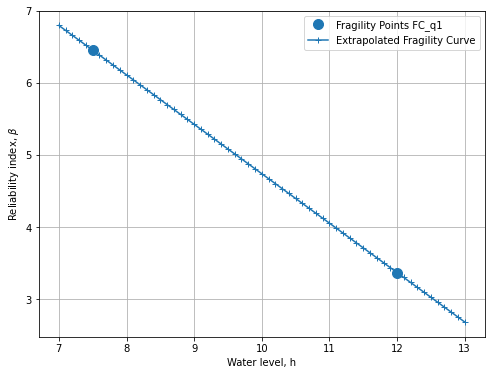

In [6]:
def plot_fragility_curves(FC_list):
    # Instantiate a figure with a specified size
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
        
    # Set the axis labels and title
    ax.set_xlabel('Water level, h')
    ax.set_ylabel(r'Reliability index, $\beta$')

    def plot_fragility_points(fig, h, b, label, color):
        # Add the fragility points to the figure
        ax.plot(h, b, color=color, marker='o', markersize=10, linestyle='none', 
                label='Fragility Points {}'.format(label))
    
    def plot_extrapolated_fragility_curve(fig, h, b, label, color):
        # Add the fragility points to the figure
        ax.plot(h, b, color=color,  marker='+', linestyle='-', 
                label='Extrapolated Fragility Curve')
     
    colors = ['tab:blue']
    for i, FC in enumerate(FC_list):
        c = colors[i]
        plot_fragility_points(fig, FC.h, FC.b, label=FC.Label, color=c)
        plot_extrapolated_fragility_curve(fig, h=FC.H, b=FC.B, label=FC.Label, color=c)
    
    plt.legend()
    plt.grid()
    return fig, ax

# Create the figure
fig, ax = plot_fragility_curves(FC_list)

# Show the figure
plt.show()

***
### Now we integrate the fragility curve with the probability density of water level.

#### Here we assume the water level follows a Gumbel distribution. 

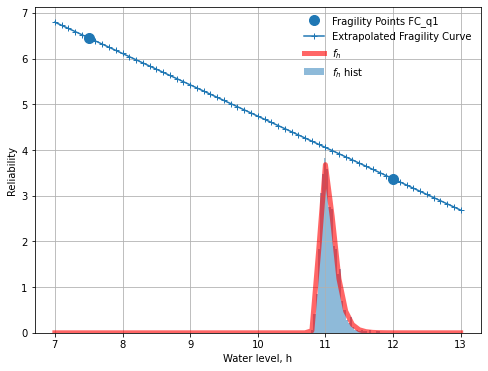

In [7]:
# Introduce the water level distribution function and plot 

## Parameters of the statistical distribution
mu= 11 
std = 0.1

## Calculating the pdf of the water level f(h); 
xnew = np.arange(range_h[0], range_h[1]+delta_h, delta_h)
fh = np.empty(len(xnew), dtype=object)

## Plot the Gumbel distribution and the fragility curve.
r = gumbel_r.rvs(loc=mu, scale=std, size=1000)
for h in range(len(xnew)):
    fh[h]=gumbel_r.pdf(xnew[h], loc=mu, scale=std)

fig, ax = plot_fragility_curves(FC_list)
plt.plot(xnew , fh,'r-', lw=5, alpha=0.6, label='$f_h$')
plt.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.5,label='$f_h$ hist' )
plt.xlabel("Water level, h")
plt.ylabel("Reliability")   
plt.legend(loc='best', frameon=False)
plt.show()

***
### Calculating the probability of exceedence for range of H

$ P_f = \int P(F|h) . f_h(h) dh $

In [8]:
## Calculating the f(h); 
xnew = np.arange(range_h[0], range_h[1]+delta_h, delta_h)
fh = np.empty(len(xnew), dtype=object)

for h in range(len(xnew)):
    fh[h]=gumbel_r.pdf(xnew[h], loc=mu, scale=std)   #Gumbel distribution

# Integrate f(h) with stepsize of delta_h -> 1
sumFh = sum(fh)*delta_h
print('Sum of $f_h$ = ', sum(fh)*delta_h )

Sum of $f_h$ =  1.0006303391435327


In [9]:
#print('The fragility curve is now desified over range {} with \
# stepsize {}:'.format(range_h,delta_h))
#print('H',FC_list[0].H)
#print('Beta',FC_list[0].B)
#print('Pf',norm.cdf(-1*FC_list[0].B)) #P(f/h)
#print('fh',fh)  #f(h)

P_fh = norm.cdf(-1*FC_list[0].B)                #P(f|h)        
Pf = P_fh* fh * delta_h                         #P(f/h)*f(h)*delta    

sumPf = sum(Pf)/sumFh
print('Total failure probability after integration = %0.2e'%(sumPf))

Beta = -1*norm.ppf(sumPf)                        #K2
print('Reliability index after integration = %0.3f'%(Beta))

Total failure probability after integration = 3.19e-05
Reliability index after integration = 3.998


***
## Calculating the influence coefficients after integration $\alpha_i | h $

$\alpha_h = \frac{u^*}{ -\beta} =\frac{ \Phi^{-1}(F_h(h^*))} { \Phi^{-1}(P_f)}$

$ \Sigma_i ( \alpha_i |h^*)^2 +\alpha_h^2 =1 $

$\alpha_{T_i} ^2 = (\alpha_i |h^*)^2(1-\alpha_h^2) $  

where:

$\alpha_{T_i} $ : transformed influence coefficient(s) of strength variable 

$ \alpha_i |h^*$: Influence coefficient(s) of strength variable, directly from FORM at design point water level (e.g., based on interpolation between fragility points)


In [10]:
#Calculating alphas in given design point water level (h_Star)
Hs= 11.067                                         

# Calculating u* for h*
P_us=gumbel_r.cdf(Hs, loc=mu, scale=std)          # \Phi^{-1}(F_h(h*))
us = st.norm.ppf(P_us)                           

print('u*, design point (genormeerde waterstand) = ', us)
print()
alphaH = us/-Beta                                #alphaH = us/-Beta

print('𝛼_ℎ (invloedscoëfficiënt van het waterstand) =', alphaH)
print()

#Getting alphas befor integrating for H^star ( interpolated through fragility curve)
a=FC_list[0].Alphas                       
for i in a.keys():                          
    values = np.array(list(a.values()))

# to see the list of parameters
print(a.keys())                               

# a function to find the related alpha set interpolated at given h*
def find_nearest(array, value):                
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest(FC_list[0].H, value=Hs)    # Finding the related 𝛼𝑖|ℎ∗  based on the h*

Alphas = np.zeros(len(values))
for i in range(len(values)):
    Alphas[i]=values[i][idx]
    
print('α_i |h^* = ', Alphas)    
print()

print('Sum of the squared influence coefficients alpha at the design point of the water level is: ',sum(Alphas**2)) 
print('Due to the linear interpolation of alpha values between the fragility points, the sum may not be equal to 1.')
print('The general recommendation in this case is to add an extra fragility point to the fragility curve close to the')
print('design point of the water level. However, for now we normalize the values to 1.')
print()

Alphas /= np.sqrt(sum(Alphas**2))
print('Sum of the normalized squared influence coefficients alpha at the design point of the water level is: ',sum(Alphas**2))


u*, design point (genormeerde waterstand) =  0.25197669527488287

𝛼_ℎ (invloedscoëfficiënt van het waterstand) = -0.06302209004084777

dict_keys(['Pop.SP 2 Below', 'ShearStrengthRatio.H_Rk_ko', 'ModelFactor', 'StrengthIncreaseExponent.H_Rk_ko', 'StrengthIncreaseExponent.H_Rk_k_shallow', 'StrengthIncreaseExponent.H_vbv_v', 'ShearStrengthRatio.H_vbv_v', 'ShearStrengthRatio.H_Rk_k_shallow', 'Pop.SP 2 Above'])
α_i |h^* =  [ 0.          0.25793011 -0.25412093  0.05968704  0.          0.
  0.7000474   0.3986752   0.07902608]

Sum of the squared influence coefficients alpha at the design point of the water level is:  0.7899213344510857
Due to the linear interpolation of alpha values between the fragility points, the sum may not be equal to 1.
The general recommendation in this case is to add an extra fragility point to the fragility curve close to the
design point of the water level. However, for now we normalize the values to 1.

Sum of the normalized squared influence coefficients alpha at 

In [11]:
# transformed influence coefficient(s) of parameters to be determined
Alpha_T = Alphas**2*(1-alphaH**2) # Alpha_T is the squared, see equation above.
print('The squared influence coefficients of the strength parameters are:\n', Alpha_T)

print()
print('Squared influence coefficient of the water level = ', 1-sum(Alpha_T))

The squared influence coefficients of the strength parameters are:
 [0.         0.08388646 0.08142705 0.00449208 0.         0.
 0.61793486 0.20041316 0.0078746 ]

Squared influence coefficient of the water level =  0.003971783833116804
